In [2]:
from tensorflow.keras import layers, models, backend, utils, metrics, preprocessing, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from PIL import Image
from wand.image import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics as skmetrics
import numpy as np
import seaborn as sns
import os
import pandas as pd
import glob
import errno
import scipy
from scipy import ndimage
import imageio


In [3]:
DIR_PREFIX  = '../input/evendata/input/real_vs_fake/real-vs-fake/'

def load_dataset(path):
    dataset = {"image_path":[],"img_status":[],"where":[]}
    for status in os.listdir(path):
        for image in glob.glob(path+"/"+status+"/"+"*.jpg"):
            dataset["image_path"].append(image)
            dataset["img_status"].append(status)
            dataset["where"].append("train")
    dataset = pd.DataFrame(dataset)
    dataset.value_counts("img_status")
    real = dataset.value_counts("img_status")[1]
    fake = dataset.value_counts("img_status")[0]

    print(f"Real: {real},\nFake: {fake}\n")
    sns.countplot(dataset["img_status"])
    plt.show()
    return dataset

def view_dataset(dataset):
    plt.figure(figsize = (14,10))
    for i in range(9):
        random = np.random.randint(1,len(dataset))
        plt.subplot(3,3,i+1)
        plt.imshow(plt.imread(dataset.loc[random,"image_path"]))
        plt.title(dataset.loc[random, "img_status"], size = 10) 
        plt.xticks([])
        plt.yticks([])

    plt.show()
    
def predict(img_path):
    input_arr = []
    count = 0
#     img_path = img_path.replace(DIR_PREFIX,'./output/')
    img = Image(filename = img_path)
    # Clone the image in order to process
    img.transform_colorspace('gray')
    img.edge(radius=2)
    img.save(filename='./output/my_test.png')
    image = preprocessing.image.load_img(
        img_path, grayscale=False, color_mode="rgb", target_size=(150, 150, 3)
    )
    i = preprocessing.image.img_to_array(image)
    input_arr = np.array([i])
    predictions = model.predict(input_arr)
    return predictions[0]

def predict_dataset(dataset):
    plt.figure(figsize = (14,10))
    for i in range(9):
        random = np.random.randint(1,len(dataset))
        plt.subplot(3,3,i+1)
        plt.imshow(plt.imread(dataset.loc[random,"image_path"]))
        predicted = predict(dataset.loc[random,"image_path"]);
        plt.title(f"{dataset.loc[random, 'img_status']} accuracy: {predicted}", size = 10) 
        plt.xticks([])
        plt.yticks([])
    

def convert_to_edge(dir_name='train'):
    try:
        os.mkdir('./output/'+dir_name)
        os.mkdir('./output/'+dir_name+'/fake')
        os.mkdir('./output/'+dir_name+'/real')
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass
    i = 0
    print('data processed for '+dir_name)
    for filename in os.listdir(DIR_PREFIX+dir_name):
        f = os.path.join(DIR_PREFIX+dir_name, filename)
        # checking if it is a file
        if os.path.isdir(f):
            convert_to_edge(dir_name+'/'+filename)
        else:
            i = i+1
            with Image(filename = f) as img:
                # Clone the image in order to process
                img.transform_colorspace('gray')
                img.edge(radius=2)
                img.save(filename=f.replace(DIR_PREFIX,'./output/'))
            print(i, end='\r')
            
try:
    os.mkdir('./output')
except OSError as exc:
    pass

Real: 4000,
Fake: 4000



/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


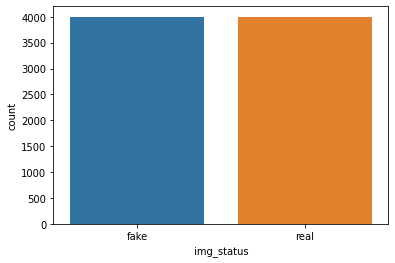

In [4]:
path  = '../input/evendata/input/real_vs_fake/real-vs-fake/train'
train_dataset = load_dataset(path)

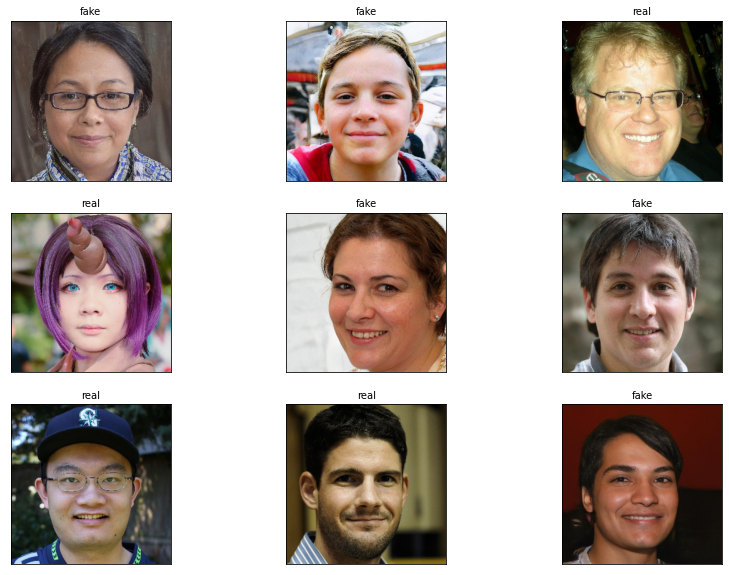

In [5]:
view_dataset(train_dataset)

In [6]:
# convert_to_edge('train')
# convert_to_edge('valid')
# convert_to_edge('test')

Real: 4000,
Fake: 4000



/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


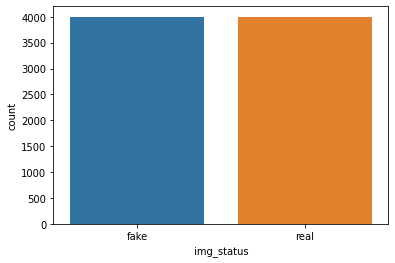

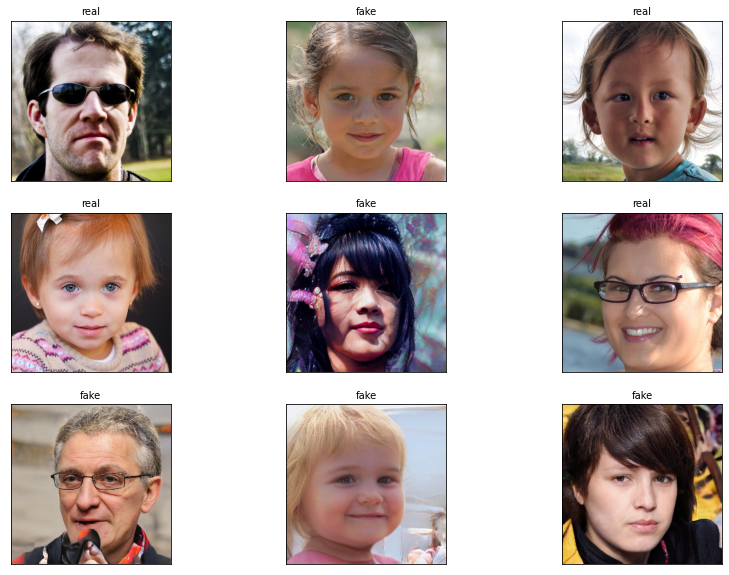

In [8]:
path  = '../input/evendata/input/real_vs_fake/real-vs-fake/train'
train_dataset_preprocessed = load_dataset(path)
view_dataset(train_dataset_preprocessed)

In [9]:
base_path = './output/'
train_flow = preprocessing.image_dataset_from_directory(
    '../input/evendata/input/real_vs_fake/real-vs-fake/train',
    image_size=(150, 150),
    batch_size=64,
    labels='inferred',
    label_mode='binary'
)
test_flow = preprocessing.image_dataset_from_directory(
    '../input/evendata/input/real_vs_fake/real-vs-fake/test',
    image_size=(150, 150),
    batch_size=64,
    labels='inferred',
    label_mode='binary'
)
valid_flow = preprocessing.image_dataset_from_directory(
    '../input/evendata/input/real_vs_fake/real-vs-fake/valid',
    image_size=(150, 150),
    batch_size=64,
    labels='inferred',
    label_mode='binary'
)
train_flow.class_names

Found 8000 files belonging to 2 classes.


2022-07-07 11:37:17.080165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 11:37:17.188655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 11:37:17.189463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 11:37:17.192374: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 3587 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


['fake', 'real']

In [18]:
model = models.Sequential()

model.add(
    layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[150, 150, 3]))

model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(layers.Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 18, 18, 256)      

In [19]:
# train_steps = 4000//64
# valid_steps = 4000//64

hist = model.fit(
    train_flow,
    epochs=10,
    validation_data=valid_flow,
    batch_size=64
)

Epoch 1/10
125/125 [==============================] - 12s 87ms/step - loss: 2.4100 - accuracy: 0.5309 - val_loss: 0.6875 - val_accuracy: 0.5280
Epoch 2/10
125/125 [==============================] - 12s 91ms/step - loss: 0.6714 - accuracy: 0.5931 - val_loss: 0.6647 - val_accuracy: 0.6000
Epoch 3/10
125/125 [==============================] - 11s 86ms/step - loss: 0.6309 - accuracy: 0.6463 - val_loss: 0.6109 - val_accuracy: 0.6625
Epoch 4/10
125/125 [==============================] - 12s 89ms/step - loss: 0.5881 - accuracy: 0.6913 - val_loss: 0.6037 - val_accuracy: 0.6795
Epoch 5/10
125/125 [==============================] - 12s 90ms/step - loss: 0.5489 - accuracy: 0.7179 - val_loss: 0.5810 - val_accuracy: 0.6980
Epoch 6/10
125/125 [==============================] - 11s 86ms/step - loss: 0.5136 - accuracy: 0.7436 - val_loss: 0.5764 - val_accuracy: 0.6955
Epoch 7/10
125/125 [==============================] - 12s 93ms/step - loss: 0.4737 - accuracy: 0.7691 - val_loss: 0.6233 - val_accuracy:

In [13]:
y_pred = model.predict(test_flow)
y_pred

array([[0.49156144],
       [0.01678884],
       [0.08965172],
       ...,
       [0.9704001 ],
       [0.9061011 ],
       [0.99403787]], dtype=float32)

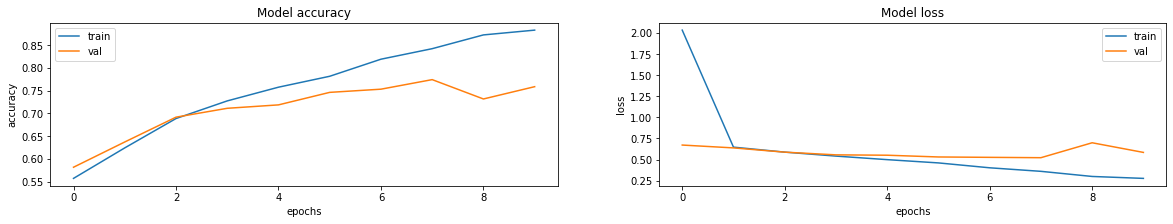

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate([ "accuracy", "loss"]):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

Real: 1694,
Fake: 1893



/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


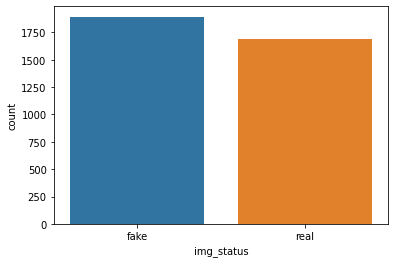

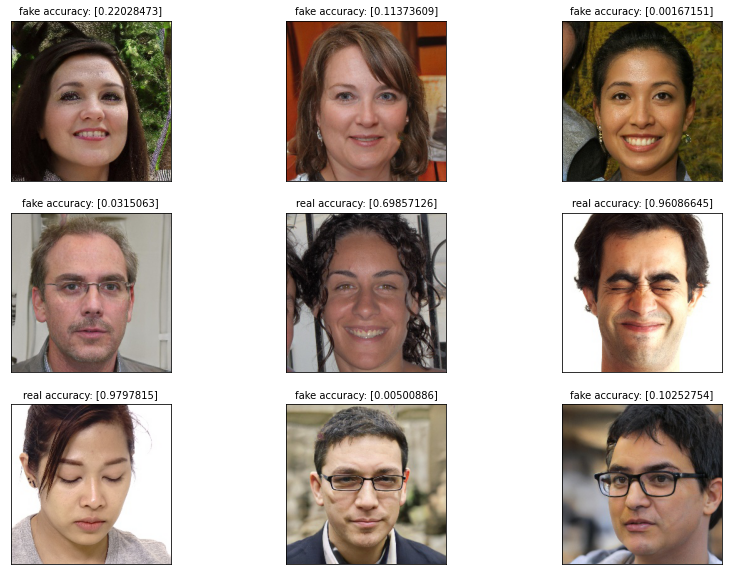

In [16]:
path  = '../input/evendata/input/real_vs_fake/real-vs-fake/test'
test_dataset = load_dataset(path)
# test_dataset
predict_dataset(test_dataset)